In [2]:
import feather
import pandas as pd
import numpy as np
import os
import geopandas as gpd
import datetime
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import gaussian_kde
import sklearn

import warnings
warnings.filterwarnings('ignore')

C:\Users\dune\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# 1. Imput Data

In [3]:
df = feather.read_dataframe("data/2021-10_odt.feather")


In [4]:
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])

df['duration(mins)'] = (df['end_time'] - df['start_time']).dt.total_seconds() / 60

In [5]:
oa_london = gpd.read_file("data/statistical-gis-boundaries-london/ESRI/OA_2011_London_gen_MHW.shp")
oa_london = oa_london.to_crs("EPSG:27700")

In [6]:
oa_london_df = pd.DataFrame(oa_london)

# merge the oa_london_df with the df, use oaid_origin in df and OA11CD in oa_london_df
df_merge = pd.merge(df, oa_london_df, left_on='oaid_origin', right_on='OA11CD', how='left')
df_merge = df_merge[['index', 'oaid_origin', 'oaid_des', 'LSOA11CD','MSOA11CD','geometry','start_time', 'end_time', 'duration(mins)']]
df_merge.rename(columns={'LSOA11CD':'LSOA11CD_origin', 'MSOA11CD':'MSOA11CD_origin','geometry':'geometry_origin'}, inplace=True)

df_merge_od = pd.merge(df_merge, oa_london_df, left_on='oaid_des', right_on='OA11CD', how='left')
df_merge_od = df_merge_od[['index', 'oaid_origin', 'oaid_des', 'LSOA11CD_origin','MSOA11CD_origin','geometry_origin','start_time', 'end_time', 'duration(mins)', 'LSOA11CD','MSOA11CD','geometry']]
df_merge_od.rename(columns={'LSOA11CD':'LSOA11CD_des', 'MSOA11CD':'MSOA11CD_des','geometry':'geometry_des'}, inplace=True)


In [7]:
df_origin = df_merge_od.drop(columns=['geometry_des'])
df_des = df_merge_od.drop(columns=['geometry_origin'])
df_origin.shape

(3138531, 11)

## MSOA to PDF

df_origin


In [8]:
MSOA_Ori_Order_Count = df_origin['MSOA11CD_origin'].value_counts()
# only filter all the origin oaid that has more than 1200 numbers
MSOA_Ori_Order_Count

MSOA11CD_origin
E02000977    35398
E02000001    33193
E02000972    27715
E02000524    14684
E02000970    13427
             ...  
E02000869      803
E02000380      773
E02000414      750
E02000432      606
E02000347      588
Name: count, Length: 983, dtype: int64

In [9]:
# save the Ori_Order_Count to a list
MSOA_Ori_Order_Count_list = MSOA_Ori_Order_Count.index.tolist()
# create a new dataframe, with 80 rows and 2000 columns, fill with 0
MSOA_origin_PDFs = pd.DataFrame(np.zeros((len(MSOA_Ori_Order_Count_list), 2880)), columns=range(2880))
# add each name in the Ori_Order_Count_list to the df as the index column
MSOA_origin_PDFs.index = MSOA_Ori_Order_Count_list
MSOA_origin_PDFs

,0,1,2,3,4,5,6,7,8,9,...,2870,2871,2872,2873,2874,2875,2876,2877,2878,2879
E02000977,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E02000001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E02000972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E02000524,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E02000970,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E02000869,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E02000380,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E02000414,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E02000432,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# iterate throught eh ori_order_count_list, and get the corresponding rows in the df_origin
for MSOAcode in MSOA_Ori_Order_Count_list:
    data_test = df_origin[df_origin['MSOA11CD_origin'] == MSOAcode]
    # Calculate the middle time between the two columns 'start_time' and 'end_time', the average time
    data_test['mid_time'] = data_test[['start_time', 'end_time']].mean(axis=1)
    # Create a new column 'hour_time' to store the number of minutes represented by 'mid_time'
    # the number of minutes after 0:00, and the type is numeric
    data_test['hour_time'] = data_test['mid_time'].dt.hour * 60 + data_test['mid_time'].dt.minute
    # Use Gaussian kernel density estimation (KDE) with weights of duration
    values = data_test['hour_time']
    weights = data_test['duration(mins)']
    kde = gaussian_kde(values, weights=weights)
    # Generates values ​​with an x-axis range of 0-1440, 2880 is the number of points
    x = np.linspace(0, 1440, 2880)
    density = kde(x)
    # Convert the result to a numpy array
    density_array = np.array(density)
    # Fill the density estimation result into the row whose index content is OAcode
    MSOA_origin_PDFs.loc[MSOAcode] = density_array

In [11]:
MSOA_origin_PDFs

,0,1,2,3,4,5,6,7,8,9,...,2870,2871,2872,2873,2874,2875,2876,2877,2878,2879
E02000977,0.000279,0.000280,0.000281,0.000283,0.000284,0.000285,0.000287,0.000288,0.000289,0.000291,...,0.000387,0.000385,0.000383,0.000381,0.000379,0.000378,0.000376,0.000374,0.000372,0.000370
E02000001,0.000232,0.000233,0.000234,0.000235,0.000235,0.000236,0.000237,0.000238,0.000239,0.000240,...,0.000272,0.000271,0.000269,0.000268,0.000266,0.000265,0.000263,0.000262,0.000260,0.000259
E02000972,0.000267,0.000268,0.000270,0.000271,0.000272,0.000273,0.000274,0.000276,0.000277,0.000278,...,0.000296,0.000295,0.000293,0.000292,0.000290,0.000289,0.000287,0.000285,0.000284,0.000282
E02000524,0.000413,0.000415,0.000416,0.000417,0.000419,0.000420,0.000421,0.000423,0.000424,0.000425,...,0.000293,0.000293,0.000292,0.000291,0.000290,0.000289,0.000288,0.000287,0.000286,0.000286
E02000970,0.000313,0.000314,0.000315,0.000317,0.000318,0.000319,0.000321,0.000322,0.000323,0.000324,...,0.000190,0.000189,0.000188,0.000187,0.000186,0.000186,0.000185,0.000184,0.000183,0.000182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E02000869,0.000051,0.000051,0.000051,0.000051,0.000051,0.000052,0.000052,0.000052,0.000052,0.000052,...,0.000189,0.000188,0.000187,0.000186,0.000185,0.000184,0.000184,0.000183,0.000182,0.000181
E02000380,0.000168,0.000169,0.000169,0.000169,0.000170,0.000170,0.000170,0.000171,0.000171,0.000171,...,0.000455,0.000454,0.000453,0.000452,0.000451,0.000450,0.000449,0.000448,0.000447,0.000447
E02000414,0.000172,0.000172,0.000173,0.000173,0.000174,0.000174,0.000175,0.000175,0.000176,0.000176,...,0.000122,0.000122,0.000121,0.000120,0.000120,0.000119,0.000119,0.000118,0.000118,0.000117
E02000432,0.000195,0.000196,0.000196,0.000197,0.000197,0.000198,0.000198,0.000199,0.000199,0.000200,...,0.000360,0.000360,0.000359,0.000358,0.000357,0.000356,0.000355,0.000355,0.000354,0.000353


df_destination

In [12]:
MSOA_Des_Order_Count = df_des['MSOA11CD_des'].value_counts()
# save the des_Order_Count to a list
MSOA_Des_Order_Count_list = MSOA_Des_Order_Count.index.tolist()
# create a new dataframe, with 80 rows and 2000 columns, fill with 0
MSOA_des_PDFs = pd.DataFrame(np.zeros((len(MSOA_Des_Order_Count_list), 2880)), columns=range(2880))
# add each name in the des_Order_Count_list to the df as the index column
MSOA_des_PDFs.index = MSOA_Des_Order_Count_list

# iterate throught des_order_count_list, and get the corresponding rows in the df_des
for MSOAcode in MSOA_Des_Order_Count_list:
    data_test = df_des[df_des['MSOA11CD_des'] == MSOAcode]
    # Calculate the middle time between the two columns 'start_time' and 'end_time', the average time
    data_test['mid_time'] = data_test[['start_time', 'end_time']].mean(axis=1)
    # Create a new column 'hour_time' to store the number of minutes represented by 'mid_time'
    # the number of minutes after 0:00, and the type is numeric
    data_test['hour_time'] = data_test['mid_time'].dt.hour * 60 + data_test['mid_time'].dt.minute
    # Use Gaussian kernel density estimation (KDE) with weights of duration
    values = data_test['hour_time']
    weights = data_test['duration(mins)']
    kde = gaussian_kde(values, weights=weights)
    # Generates values ​​with an x-axis range of 0-1440, 2880 is the number of points
    x = np.linspace(0, 1440, 2880)
    density = kde(x)
    # Convert the result to a numpy array
    density_array = np.array(density)
    # Fill the density estimation result into the row whose index content is OAcode
    MSOA_des_PDFs.loc[MSOAcode] = density_array
    
MSOA_des_PDFs

,0,1,2,3,4,5,6,7,8,9,...,2870,2871,2872,2873,2874,2875,2876,2877,2878,2879
E02000977,0.000222,0.000223,0.000224,0.000225,0.000227,0.000228,0.000229,0.000230,0.000231,0.000232,...,0.000226,0.000225,0.000224,0.000223,0.000221,0.000220,0.000219,0.000218,0.000216,0.000215
E02000001,0.000262,0.000263,0.000264,0.000265,0.000266,0.000268,0.000269,0.000270,0.000271,0.000272,...,0.000241,0.000240,0.000239,0.000238,0.000237,0.000236,0.000235,0.000234,0.000233,0.000232
E02000972,0.000243,0.000244,0.000245,0.000246,0.000248,0.000249,0.000250,0.000251,0.000252,0.000253,...,0.000252,0.000251,0.000250,0.000249,0.000248,0.000247,0.000246,0.000245,0.000244,0.000243
E02000524,0.000434,0.000435,0.000436,0.000438,0.000439,0.000440,0.000441,0.000442,0.000443,0.000445,...,0.000296,0.000295,0.000294,0.000294,0.000293,0.000292,0.000291,0.000290,0.000289,0.000288
E02000978,0.000247,0.000248,0.000249,0.000250,0.000251,0.000252,0.000253,0.000254,0.000255,0.000256,...,0.000252,0.000251,0.000250,0.000249,0.000248,0.000248,0.000247,0.000246,0.000245,0.000244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E02000380,0.000151,0.000151,0.000152,0.000152,0.000152,0.000153,0.000153,0.000153,0.000153,0.000154,...,0.000293,0.000292,0.000292,0.000291,0.000290,0.000289,0.000289,0.000288,0.000287,0.000286
E02006918,0.000372,0.000372,0.000373,0.000374,0.000375,0.000376,0.000377,0.000377,0.000378,0.000379,...,0.000246,0.000245,0.000244,0.000244,0.000243,0.000243,0.000242,0.000241,0.000241,0.000240
E02000356,0.000404,0.000405,0.000405,0.000406,0.000407,0.000408,0.000409,0.000410,0.000411,0.000412,...,0.000109,0.000108,0.000108,0.000108,0.000107,0.000107,0.000107,0.000106,0.000106,0.000106
E02000347,0.000148,0.000148,0.000148,0.000149,0.000149,0.000149,0.000150,0.000150,0.000150,0.000150,...,0.000229,0.000228,0.000228,0.000227,0.000227,0.000226,0.000225,0.000225,0.000224,0.000223


## OA to PDF

df_origin

In [13]:
Ori_Order_Count = df_origin['oaid_origin'].value_counts()
# only filter all the origin oaid that has more than 1200 numbers
Ori_Order_Count = Ori_Order_Count[Ori_Order_Count > 1600]
Ori_Order_Count

oaid_origin
E00166755    11395
E00012179     6104
E00175033     5322
E00000035     5172
E00023930     5150
             ...  
E00005226     1683
E00013428     1678
E00023932     1645
E00007499     1625
E00020536     1607
Name: count, Length: 80, dtype: int64

In [14]:
# save the Ori_Order_Count to a list
Ori_Order_Count_list = Ori_Order_Count.index.tolist()

In [15]:
# create a new dataframe, with 80 rows and 2000 columns, fill with 0
df_origin_PDFs = pd.DataFrame(np.zeros((len(Ori_Order_Count_list), 2880)), columns=range(2880))
# add each name in the Ori_Order_Count_list to the df as the index column
df_origin_PDFs.index = Ori_Order_Count_list
df_origin_PDFs

,0,1,2,3,4,5,6,7,8,9,...,2870,2871,2872,2873,2874,2875,2876,2877,2878,2879
E00166755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E00012179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E00175033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E00000035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E00023930,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E00005226,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E00013428,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E00023932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E00007499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
'''
OAcode = "E00023930"
data_test = df_origin[df_origin['oaid_origin'] == OAcode]
data_test['mid_time'] = data_test[['start_time', 'end_time']].mean(axis=1)
data_test['hour_time'] = data_test['mid_time'].dt.hour * 60 + data_test['mid_time'].dt.minute
values = data_test['hour_time']
weights = data_test['duration(mins)']
kde = gaussian_kde(values, weights=weights)
x = np.linspace(0, 1440, 2880)
density_array = np.array(density)
df_origin_PDFs.loc[OAcode] = density_array
'''

'\nOAcode = "E00023930"\ndata_test = df_origin[df_origin[\'oaid_origin\'] == OAcode]\ndata_test[\'mid_time\'] = data_test[[\'start_time\', \'end_time\']].mean(axis=1)\ndata_test[\'hour_time\'] = data_test[\'mid_time\'].dt.hour * 60 + data_test[\'mid_time\'].dt.minute\nvalues = data_test[\'hour_time\']\nweights = data_test[\'duration(mins)\']\nkde = gaussian_kde(values, weights=weights)\nx = np.linspace(0, 1440, 2880)\ndensity_array = np.array(density)\ndf_origin_PDFs.loc[OAcode] = density_array\n'

In [17]:
# iterate throught eh ori_order_count_list, and get the corresponding rows in the df_origin
for OAcode in Ori_Order_Count_list:
    data_test = df_origin[df_origin['oaid_origin'] == OAcode]

    data_test['mid_time'] = data_test[['start_time', 'end_time']].mean(axis=1)

    data_test['hour_time'] = data_test['mid_time'].dt.hour * 60 + data_test['mid_time'].dt.minute

    values = data_test['hour_time']
    weights = data_test['duration(mins)']
    kde = gaussian_kde(values, weights=weights)

    x = np.linspace(0, 1440, 2880)
    density = kde(x)

    density_array = np.array(density)

    df_origin_PDFs.loc[OAcode] = density_array

In [1]:
df_origin_PDFs

NameError: name 'df_origin_PDFs' is not defined

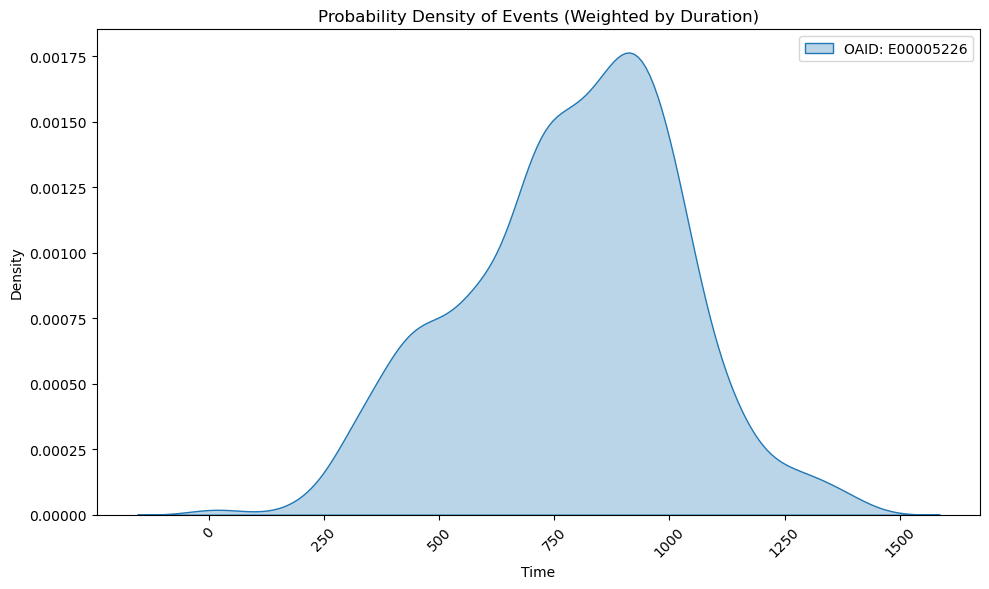

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
oaid_data = data_test[data_test['oaid_origin'] == 'E00005226']
    
kde = sns.kdeplot(
    x=oaid_data['hour_time'],
    #weights=oaid_data['duration(mins)'],
    fill=True,
    alpha=0.3,
    label=f'OAID: E00005226',
    ax=ax
)

#ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
#ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.xticks(rotation=45)

plt.xlabel('Time')
plt.ylabel('Density')
plt.title('Probability Density of Events (Weighted by Duration)')
plt.legend()
plt.tight_layout()

plt.show()

df_destination

In [36]:
Des_Order_Count = df_des['oaid_des'].value_counts()
Des_Order_Count = Des_Order_Count[Des_Order_Count > 1600]

Des_Order_Count_list = Des_Order_Count.index.tolist()

# create a new dataframe
df_des_PDFs = pd.DataFrame(np.zeros((len(Des_Order_Count_list), 2880)), columns=range(2880))
df_des_PDFs.index = Des_Order_Count_list

for OAcode in Des_Order_Count_list:
    data_test = df_des[df_des['oaid_des'] == OAcode]

    data_test['mid_time'] = data_test[['start_time', 'end_time']].mean(axis=1)

    data_test['hour_time'] = data_test['mid_time'].dt.hour * 60 + data_test['mid_time'].dt.minute

    values = data_test['hour_time']
    weights = data_test['duration(mins)']
    kde = gaussian_kde(values, weights=weights)

    x = np.linspace(0, 1440, 2880)
    density = kde(x)

    density_array = np.array(density)

    df_des_PDFs.loc[OAcode] = density_array

In [39]:
df_des_PDFs

,0,1,2,3,4,5,6,7,8,9,...,2870,2871,2872,2873,2874,2875,2876,2877,2878,2879
E00166755,0.000227,0.000228,0.000228,0.000229,0.000230,0.000230,0.000231,0.000232,0.000232,0.000233,...,0.000266,0.000265,0.000264,0.000263,0.000263,0.000262,0.000261,0.000260,0.000259,0.000258
E00012179,0.000441,0.000441,0.000442,0.000443,0.000444,0.000445,0.000446,0.000447,0.000448,0.000448,...,0.000338,0.000337,0.000337,0.000336,0.000335,0.000334,0.000333,0.000333,0.000332,0.000331
E00175206,0.000253,0.000254,0.000255,0.000256,0.000257,0.000258,0.000259,0.000260,0.000261,0.000261,...,0.000271,0.000270,0.000269,0.000268,0.000267,0.000266,0.000265,0.000264,0.000263,0.000262
E00175033,0.000201,0.000202,0.000203,0.000203,0.000204,0.000205,0.000206,0.000206,0.000207,0.000208,...,0.000139,0.000139,0.000138,0.000137,0.000137,0.000136,0.000136,0.000135,0.000134,0.000134
E00023930,0.000230,0.000231,0.000231,0.000232,0.000233,0.000234,0.000234,0.000235,0.000236,0.000237,...,0.000204,0.000203,0.000203,0.000202,0.000201,0.000201,0.000200,0.000199,0.000199,0.000198
E00023935,0.000234,0.000235,0.000235,0.000236,0.000237,0.000237,0.000238,0.000238,0.000239,0.000240,...,0.000279,0.000279,0.000278,0.000277,0.000276,0.000275,0.000274,0.000273,0.000272,0.000271
E00008308,0.000298,0.000299,0.000300,0.000301,0.000302,0.000303,0.000304,0.000305,0.000306,0.000307,...,0.000153,0.000152,0.000152,0.000151,0.000151,0.000150,0.000150,0.000149,0.000148,0.000148
E00004734,0.000148,0.000148,0.000149,0.000149,0.000150,0.000150,0.000151,0.000151,0.000152,0.000152,...,0.000165,0.000164,0.000163,0.000162,0.000162,0.000161,0.000160,0.000159,0.000159,0.000158
E00000035,0.000320,0.000321,0.000322,0.000323,0.000324,0.000324,0.000325,0.000326,0.000327,0.000328,...,0.000248,0.000247,0.000246,0.000246,0.000245,0.000244,0.000244,0.000243,0.000242,0.000242
E00018353,0.000154,0.000154,0.000155,0.000155,0.000156,0.000157,0.000157,0.000158,0.000158,0.000159,...,0.000191,0.000191,0.000190,0.000189,0.000188,0.000188,0.000187,0.000186,0.000185,0.000185


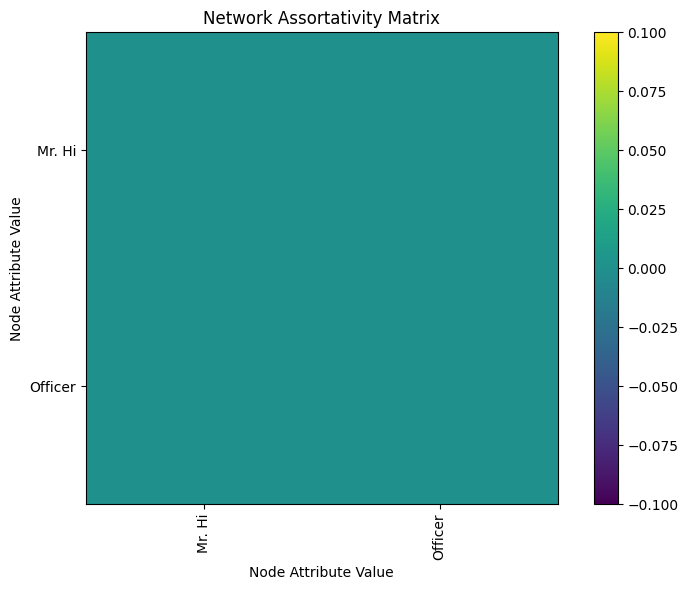

In [37]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Create a sample graph
G = nx.karate_club_graph()

# Get the unique node attribute values
node_attributes = nx.get_node_attributes(G, "club")
unique_attributes = set(node_attributes.values())

# Calculate the assortativity coefficients
assortativity_coeffs = {}
for attr in unique_attributes:
    assortativity_coeffs[attr] = nx.attribute_assortativity_coefficient(G, "club", attr)

# Construct the assortativity matrix
assortativity_matrix = np.zeros((len(unique_attributes), len(unique_attributes)))
attributes_list = list(unique_attributes)
for i, attr_i in enumerate(attributes_list):
    for j, attr_j in enumerate(attributes_list):
        assortativity_matrix[i, j] = assortativity_coeffs.get((attr_i, attr_j), 0)

# Plot the assortativity matrix
plt.figure(figsize=(8, 6))
plt.imshow(assortativity_matrix, cmap="viridis")
plt.colorbar()
plt.title("Network Assortativity Matrix")
plt.xlabel("Node Attribute Value")
plt.ylabel("Node Attribute Value")
plt.xticks(range(len(unique_attributes)), attributes_list, rotation=90)
plt.yticks(range(len(unique_attributes)), attributes_list)
plt.tight_layout()
plt.show()